# Libraries

In [2]:
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from collections import defaultdict
from collections import Counter
import math
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt

# Cleaning the Data

In [ ]:
path = '/Users/domenicomattiacinque/Documents/Università/ADM2020/HW4/archive'
dataset = pd.read_csv(path + '/Reviews.csv', nrows = 10000)

In [ ]:
dataset.head()

In [ ]:
dataset.isnull().sum()

In [ ]:
dataset['Summary'].fillna('', inplace=True)

In [ ]:
dataset['Text'] = dataset['Summary'] + ' ' + dataset['Text'] 

In [ ]:
dataset.drop(['UserId','ProfileName','HelpfulnessNumerator',
              'HelpfulnessDenominator','Score','Time','Summary'],axis=1, inplace=True)

In [ ]:
dataset.head()

In [ ]:
dataset['ProductId'].nunique()

In [ ]:
df = dataset.groupby('ProductId')['Text'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
df.head()

# Text Mining
We want to cluster the products using the reviews that we can find in the column 'Text' of our dataset. In order to do this we need to represent the reviews as TF-IDF score used in the previous homework.

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [ ]:
#Realizing the cleaned token 
def clean_text(text):
    words = word_tokenize(text)
    tagged = nltk.pos_tag(words)
    
    good_words = []
    for word,tag in tagged:
        if tag == 'NN' or tag == 'NNS' or tag =='NNPS' or tag == 'NNP':
            if word.lower() not in stop_words and word.isalpha() and word.lower() not in string.punctuation:
                good_words.append(ps.stem(word).lower())
    return good_words

In [ ]:
#test
print(df['Text'][0])
print(clean_text(df['Text'][0]))

In [ ]:
#Applying the clean_text function to each element of the column 'Text'
df['Text_Words'] = df.Text.apply(lambda x: clean_text(x))

In [ ]:
df.head(5)

In [ ]:
df = pd.read_csv('new_reviews.csv')

In [ ]:
df.Text_Words = df.Text_Words.apply(literal_eval)
df.head()

In [ ]:
def vocabulary(df):
    words = defaultdict(list)
    for i,el in enumerate(df['Text_Words']):
        for w in el:
            words[w].append(i)
    return words
voc = vocabulary(df)

In [ ]:
#counting the ripetition of each token for each plot
df["Text_Ripetition"] = df["Text_Words"].apply(lambda x : Counter(x))

In [ ]:
df.head()

In [ ]:
def tf_i(text):
    tot_token = 0
    for k, v in text.items():
        tot_token += v #numbers of total tokens in the plot
    tf = {}
    for token, rip in text.items():#the values in this dictionary are the ripetition of that specific token
        tf[token] = round(rip / tot_token,4)
    return tf 

In [ ]:
tf = []
for i in range(len(df['Text_Ripetition'])):
    tf.append(tf_i(df["Text_Ripetition"][i])) #applying the previous function to each plot
df["Tf"] = tf #adding the column tf to the dataset

In [ ]:
df.head()

In [ ]:
idf = {}
for el in df['Text_Words']:   
    for token in el:
         idf.update({ token : round(math.log(len(df)/ len(voc[token]),3))})  #applying the formula for each token 

In [ ]:
# Creating a vocabulary that as keys as the word and as values its index
def vocabulary_words(df):
    words = dict()
    i = 0
    for el in tqdm(df['Text_Words']):
        for w in el:
            if w not in words.keys():
                words[w] = i
                i += 1
    return words

In [ ]:
voc_words = vocabulary_words(df)

In [ ]:
def score(dictionary):
    v = [0]*(len(voc_words))
    for word in dictionary.keys():
        v[voc_words[word]] = dictionary[word]*idf[word]
    return v

In [ ]:
from scipy.sparse import lil_matrix

matrix = lil_matrix((len(df), len(voc_words)), dtype=np.float)
for i in tqdm(range(len(df["Tf"]))):
    matrix[i] = np.array(score(df["Tf"][i]))

In [ ]:
from scipy.sparse import csr_matrix

matrix = csr_matrix(matrix)

## Dimensionality Reduction

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
matrix.shape

In [ ]:
svd = TruncatedSVD(n_components=2000, random_state=42)
svd.fit(matrix)

In [ ]:
print(svd.explained_variance_ratio_.sum())

In [ ]:
svd_matrix = svd.transform(matrix)

In [ ]:
svd_matrix.shape

## Implement KMeans from scratch
### Step 0 
Elbow method to choose the number of clusters k 
### Step 1
Random inizialization of the k representative points
### Step 2
Find the cluster $C_i$ defined as $\{x : \parallel x-\mu_i\parallel \leq \parallel x-\mu_j\parallel \forall j\ne i\}  \forall i=1..k$
### Step 3 
Find $\mu_i$ which is defined as $\frac{1}{|C_i|} \sum_{x\in C_i} x \;\; \forall i=1..k$
<hr>
Repeat step 2 and step 3 until <b>convergence</b>.

### Convergence
We stop when the clusters don't change from the previous iteration.

In [12]:
import random

In [13]:
def euclidian_dist(x,y):
    return np.linalg.norm(x-y)

In [54]:
def KMeans(k, matrix):
    # 1. Choosing k random representatives
    representatives_idx = random.sample(range(1, len(matrix)), k)  #Chosing the initial representatives
    new_representatives =  []
    for i in range(k):
        new_representatives.append(matrix[representatives_idx[i]])
    representatives = []
    
    run = True
    limit = 0
    while run:
        representatives = new_representatives
        
        # Creating the clusters
        clusters = {i: [] for i in range(k)}  # Empty dictionary for each cluster with list as value 
        i_clusters = {i: [] for i in range(k)}
        
        # 2. Computing distances and choosing 
        for ind, point in enumerate(matrix):
            dist_xmu = []      # Distance between the point and the representatives for each representative
            for i in range(k): 
                dist_xmu.append(euclidian_dist(representatives[i], point))
            nearest_representative = dist_xmu.index(min(dist_xmu))
            clusters[nearest_representative].append(point) #Put the point in the cluster with the minimum distance
            i_clusters[nearest_representative].append(ind)
            
        # 3. Selecting new representatives
        new_representatives = []
        for i in range(k):
            run = False
            new_val = np.sum(clusters[i],axis=0)/len(clusters[i])
            new_representatives.append(new_val)
            if representatives[i][0] != new_representatives[i][0] or representatives[i][1] != new_representatives[i][1]:
                run = True
                
        if run:
            limit += 1
        else:
            limit += 1
            print("n. iterations: "+str(limit))
                
        if limit == 10000:
            print("n. iterations: "+str(limit))
            return clusters, new_representatives, i_clusters
                
    return clusters, new_representatives, i_clusters

In [ ]:
clusters, new_representatives, i_clusters = KMeans(10, svd_matrix)

In [ ]:
list(df.iloc[i_clusters[5]].Text)[50]

## Cluster Analysis 

In [70]:
file = open("test.txt", "r")
matrix = []
for num in file:
    row = num.split()
    row[0] = int(row[0])
    row[1] = int(row[1])
    row = np.array(row)
    matrix.append(row)

In [76]:
def plot_cluster(clusters, centroids):
    plt.figure(figsize=(7, 7))
    for i in range(len(clusters)):
        plt.scatter(np.array(clusters[i])[:, 0], np.array(clusters[i])[:, 1], alpha=0.1)
    plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], color='black')
    plt.show()

In [74]:
def inertia(matrix, centroid, k):
    sq_norms = [] #consideranting the norms of xi - muj where i is fixed and j is in range(k)
    sum_ = 0
    for i in range(len(matrix)):
        sq_norms = []
        for j in range(k):
            sq_norm = euclidian_dist(matrix[i],centroid[j])**2 # squared norm between xi and muj
            sq_norms.append(sq_norm) #saving the result in the j-th position of sq_norms array
        min_sq_norm = min(sq_norms) #considering the minimum norm
        sum_ += min_sq_norm
    return sum_ #return inertia

==== 1 clusters ====

n. iterations: 2


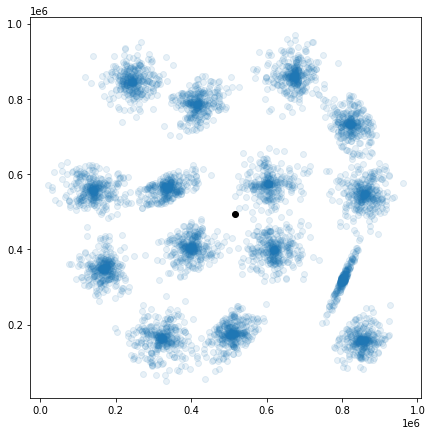

==== 2 clusters ====

n. iterations: 9


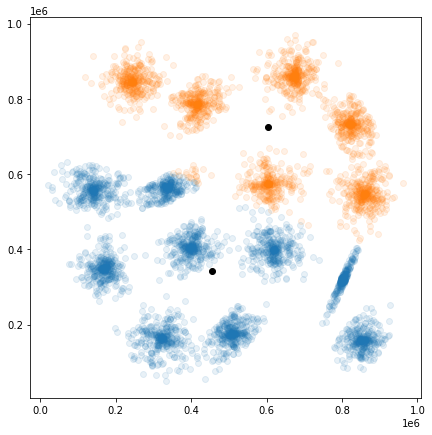

==== 3 clusters ====

n. iterations: 11


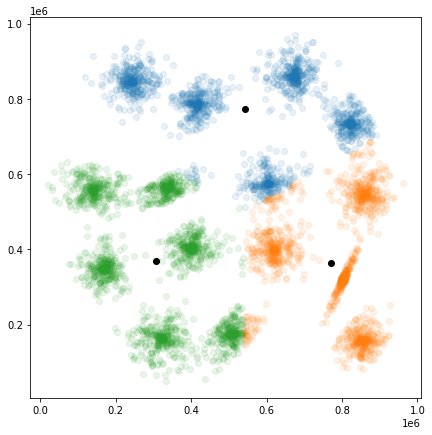

==== 4 clusters ====

n. iterations: 9


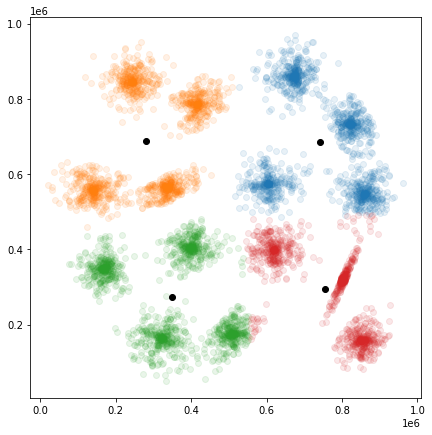

==== 5 clusters ====

n. iterations: 19


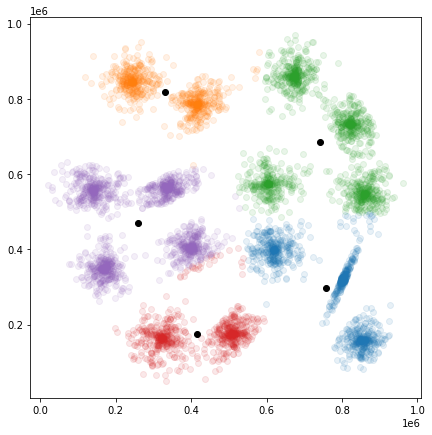

==== 6 clusters ====

n. iterations: 9


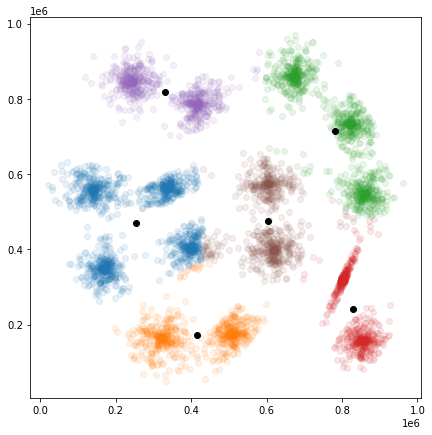

==== 7 clusters ====

n. iterations: 9


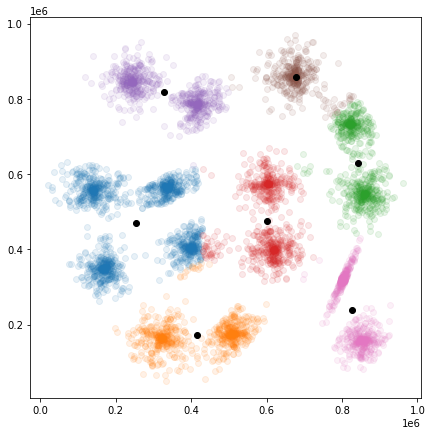

==== 8 clusters ====

n. iterations: 10


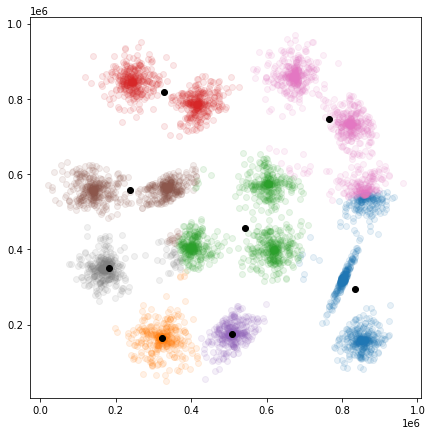

==== 9 clusters ====

n. iterations: 4


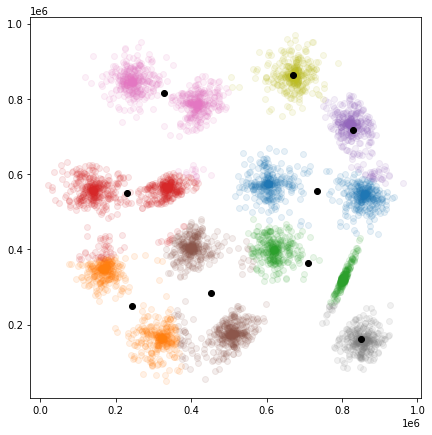

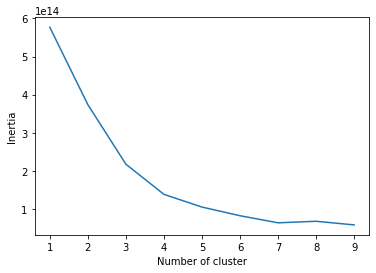

In [77]:
elbow = []
for k in range(1, 10):
    print("==== "+str(k)+" clusters ====\n")
    clusters, representatives, i_clusters = KMeans(k, matrix)
    plot_cluster(clusters, representatives)
    inertia_ = inertia(matrix, representatives, k) 
    elbow.append(inertia_)
    
plt.figure()
plt.plot(range(1,10), elbow)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()